<a href="https://colab.research.google.com/github/arkeodev/time-series/blob/main/Statistical_Time_Series_Analysis/12-ARMA-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12. ARMA Models

## 1. Introduction

The ARMA model is powerful because it accounts for both the momentum or persistence of the time series (via the AR part) and the immediate effects of new shocks or information not captured by the model in the previous term (via the MA part). 

This dual nature allows the ARMA model to fit a wide range of time series data that may not be well-described by either an AR or MA model alone.

## 2. Mathematical Definition

The ARMA(1,1) model equation is given by:
$$
r_t = c + \phi_1 r_{t-1} + \theta_1 \varepsilon_{t-1} + \varepsilon_t
$$

- $ r_t $: The observed value of the time series at time t.
- $ r_{t-1} $: The observed value of the time series at time t-1 (one period prior).
- $ \varepsilon_t\,\ \varepsilon_{t-1} $: The error terms (residuals or innovations) at time t and t-1, respectively. These are the random shocks that were not predicted by the model in the current and previous period.
- $ c $: A constant term that represents the baseline level of the time series. It's like the intercept in a regression model.
- $ \phi_1 $: The coefficient that measures the impact of the last period’s value on the current value (AR component).
- $ \theta_1 $: The coefficient that measures the impact of the last period’s forecast error on the current value (MA component).

This equation states that the current value of the time series is a function of:

- The constant baseline value $ c $,
- The weighted contribution of the last period’s value $ \phi_1 r_{t-1} $,
- The weighted contribution of the last period’s error $ \theta_1 \varepsilon_{t-1} $,
- Plus the random shock occurring in the current period $ \varepsilon_t $.



## 3. Implementation

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -344.792
Date:                Thu, 02 Jan 2025   AIC                            701.584
Time:                        17:22:22   BIC                            722.713
Sample:                             0   HQIC                           710.088
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0094      0.212     -0.045      0.964      -0.424       0.405
ar.L1          0.8638      0.154      5.627      0.000       0.563       1.165
ar.L2         -0.3802      0.117     -3.244      0.0

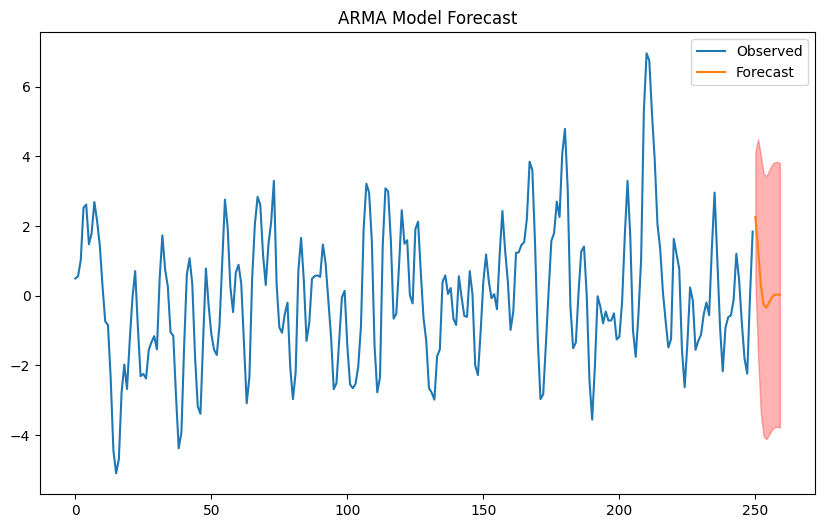

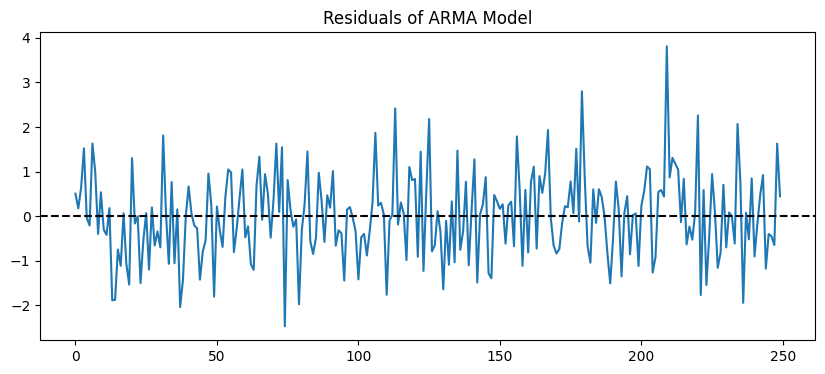

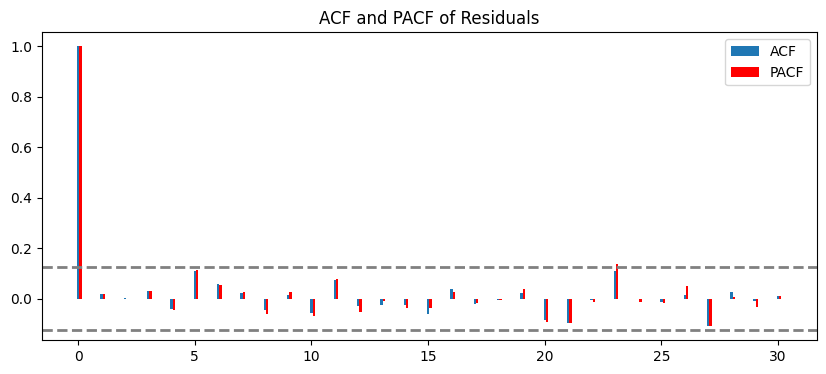

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

# Set seed for reproducibility
np.random.seed(42)

# -----------------------------------------------------------------------------------
# Step 1: Define AR and MA parameters for an ARMA(2,2) process
# -----------------------------------------------------------------------------------
# AR(2) parameters: [0.75, -0.25] 
# MA(2) parameters: [0.65, 0.35]
#
# Note that for statsmodels, we need to specify the polynomial in the form:
#   (1 - φ1L - φ2L^2) for AR
#   (1 + θ1L + θ2L^2) for MA
# where L is the lag operator.
# Hence, we prepend 1 and negate the AR params to get [1, -φ1, -φ2],
# and prepend 1 for the MA params to get [1, θ1, θ2].
# -----------------------------------------------------------------------------------
ar_params = np.array([0.75, -0.25])
ma_params = np.array([0.65, 0.35])
ar = np.r_[1, -ar_params]  # This becomes [1, -0.75, 0.25]
ma = np.r_[1, ma_params]   # This becomes [1, 0.65, 0.35]

# -----------------------------------------------------------------------------------
# Step 2: Generate the ARMA(2,2) process
# -----------------------------------------------------------------------------------
# We use ArmaProcess from statsmodels to generate a sample time series 
# from the defined AR and MA polynomials. The sample size is 250 observations.
# -----------------------------------------------------------------------------------
arma_process = ArmaProcess(ar, ma)
y = arma_process.generate_sample(nsample=250)

# -----------------------------------------------------------------------------------
# Step 3: Fit an ARMA model to the generated data using ARIMA with (p,d,q) = (2,0,2)
# -----------------------------------------------------------------------------------
# Note: In statsmodels, the ARMA(p,q) model is generally fit through ARIMA(p,0,q).
# We specify order=(2, 0, 2) here to match our data generation process.
# -----------------------------------------------------------------------------------
model = ARIMA(y, order=(2, 0, 2))
fit = model.fit()

# -----------------------------------------------------------------------------------
# Step 4: Print the summary of the fitted ARMA(2,2) model
# -----------------------------------------------------------------------------------
model_summary = fit.summary()
print(model_summary)

# -----------------------------------------------------------------------------------
# Step 5: Forecast the next 10 values based on the fitted model
# -----------------------------------------------------------------------------------
# We use get_forecast(steps=10) to predict future observations. 
# predicted_mean gives the forecasted values, and conf_int provides the 
# confidence intervals for the forecast.
# -----------------------------------------------------------------------------------
forecast = fit.get_forecast(steps=10)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval

# -----------------------------------------------------------------------------------
# Step 6: Plot the observed time series and the forecast
# -----------------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(y, label='Observed')  # Plot the original series
# Plot forecasted values in the range [len(y), len(y)+10)
plt.plot(range(len(y), len(y) + 10), forecast_mean, label='Forecast')
# Fill the area between the lower and upper confidence bounds
plt.fill_between(range(len(y), len(y) + 10), conf_int[:, 0], conf_int[:, 1],
                 color='red', alpha=0.3)
plt.title('ARMA Model Forecast')
plt.legend()
plt.show()

# -----------------------------------------------------------------------------------
# Step 7: Extract and plot the residuals
# -----------------------------------------------------------------------------------
# Residuals are the differences between observed values and the fitted values.
# Plotting them helps us visually inspect if there's any pattern or autocorrelation.
# -----------------------------------------------------------------------------------
residuals = fit.resid

plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of ARMA Model')
plt.axhline(0, color='black', linestyle='--')  # Horizontal line at 0
plt.show()

# -----------------------------------------------------------------------------------
# Step 8: ACF and PACF plots of the residuals
# -----------------------------------------------------------------------------------
# We use ACF and PACF to check if the residuals are white noise 
# (i.e., no significant autocorrelations). If the model is well-fit, 
# most lags should lie within the confidence bounds.
# -----------------------------------------------------------------------------------
lags = 30
acf_vals = acf(residuals, fft=False, nlags=lags)
pacf_vals = pacf(residuals, nlags=lags)

# Approximate 95% confidence interval for ACF/PACF 
conf_interval = 1.96 / np.sqrt(len(y))  

plt.figure(figsize=(10, 4))
# We shift the PACF bars slightly (by 0.1) to distinguish them from ACF
plt.bar(range(len(acf_vals)), acf_vals, width=0.1, label='ACF')
plt.bar(np.arange(len(pacf_vals)) + 0.1, pacf_vals, width=0.1, 
        label='PACF', color='red')

# Plot the confidence bounds
plt.axhline(-conf_interval, color='grey', linestyle='--', linewidth=2)
plt.axhline(conf_interval, color='grey', linestyle='--', linewidth=2)

plt.title('ACF and PACF of Residuals')
plt.legend()
plt.show()

In the ACF and PACF plots it may seem clearly that the (2, 2) model learns all the model patterns.

Now let's show the summary of the model.

In [5]:
from scipy.stats import chi2

def llr_test(simple, complex, degree_of_freedom=1):
    # Compare the Log Likelihood Ratio to decide which model is better
    l1 = simple.fit().llf
    l2 = complex.fit().llf
    lr = (2 * (l2 - l1))
    p = chi2.sf(lr, degree_of_freedom).round(2)
    # If the p value is less than %5 then complex model is preferrable
    preferred = "Complex model" if p <= 0.05 else "Simple Model"
    print(f"The preferred model is: {preferred}")
    return p


def compare_models(fit1, model1_name, fit2, model2_name):
    # Assume we have two fitted models, `fit1` and `fit2`
    print(f"Summary of the model {model1_name}")
    summary1 = fit1.summary()
    print(f"{summary1}\n\n")
    print(f"Summary of the model {model2_name}")
    summary2 = fit2.summary()
    print(summary2)

    # Compare the AIC and BIC to decide which model is better
    # Lower AIC and BIC indicate a better model
    better_aic_model = model1_name if (fit1.aic < fit2.aic and fit1.bic < fit2.bic) else model2_name
    print(f"\n\nThe better model based on AIC and BIC is: {better_aic_model}")


Let's compare ARMA(2,2) with ARMA(1,1)

In [6]:
complex = ARIMA(y, order= (2, 0, 2))
arma_ret_2_2 = complex.fit()

simple = ARIMA(y, order= (1, 0, 1))
arma_ret_1_1 = simple.fit()

compare_models(arma_ret_2_2, "arma_ret_2_2", arma_ret_1_1, "arma_ret_1_1")
llr_test(simple, complex, degree_of_freedom=2)


Summary of the model arma_ret_2_2
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -344.792
Date:                Thu, 02 Jan 2025   AIC                            701.584
Time:                        17:23:16   BIC                            722.713
Sample:                             0   HQIC                           710.088
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0094      0.212     -0.045      0.964      -0.424       0.405
ar.L1          0.8638      0.154      5.627      0.000       0.563       1.165
ar.L2         -0.3

0.0

 Let's compare ARMA(2,2) with ARMA(3,3) 

In [7]:
simple = ARIMA(y, order= (2, 0, 2))
arma_ret_2_2 = simple.fit()

complex = ARIMA(y, order= (3, 0, 3))
arma_ret_3_3 = complex.fit()

compare_models(arma_ret_2_2, "arma_ret_2_2", arma_ret_1_1, "arma_ret_3_3")
llr_test(simple, complex, degree_of_freedom=2)

Summary of the model arma_ret_2_2
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -344.792
Date:                Thu, 02 Jan 2025   AIC                            701.584
Time:                        17:24:14   BIC                            722.713
Sample:                             0   HQIC                           710.088
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0094      0.212     -0.045      0.964      -0.424       0.405
ar.L1          0.8638      0.154      5.627      0.000       0.563       1.165
ar.L2         -0.3

0.1

**Result**

Even though the p values of all the variables are significant for all the models, (2, 2) model produces the best result for the LLR Test and AIC, BIC tests. Then we shuld select (2, 2) model.